In [14]:
NUM_SENTENCES = 20000 # Use only the first 20,000 records.
MAX_NUM_WORDS = 20000 # Use 20,000 words for tokenizing
MAX_SENT_LEN = 50

EMBEDDING_SIZE = 100

LSTM_NEURONS = 100

BATCH_SIZE = 64
EPOCHS = 5

In [15]:
inputs = []
outputs_i = []
outputs = []

data_file = open('data/spa-eng/spa.txt', encoding='utf-8')

count = 0
for line in data_file:
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    ip, temp_op, extra = line.rstrip().split('\t')
    op_i = '<sos> '+temp_op
    op = temp_op+' <eos>'
    inputs.append(ip)
    outputs_i.append(op_i)
    outputs.append(op)

print('Total inputs =', len(inputs))
print('Total intermediate outputs =', len(outputs_i))
print('Total outputs =', len(outputs))
print('\nSample:')
print(inputs[100])
print(outputs_i[100])
print(outputs[100])

Total inputs = 20000
Total intermediate outputs = 20000
Total outputs = 20000

Sample:
Got it?
<sos> ¿Entendiste?
¿Entendiste? <eos>


In [16]:
from keras.preprocessing.text import Tokenizer

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(inputs)

inputs_seq = input_tokenizer.texts_to_sequences(inputs)

inputs_word2index = input_tokenizer.word_index
print('Total unique words in input:', len(inputs_word2index))

inputs_numwords = len(inputs_word2index)+1

inputs_maxlen = max(len(s) for s in inputs_seq)
print('Length of longest sentence in input:', inputs_maxlen)

output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(outputs_i + outputs)

outputs_i_seq = output_tokenizer.texts_to_sequences(outputs_i)
outputs_seq = output_tokenizer.texts_to_sequences(outputs)

outputs_word2index = output_tokenizer.word_index
print('Total unique words in output:', len(outputs_word2index))

outputs_numwords = len(outputs_word2index)+1

outputs_maxlen = max(len(s) for s in outputs_seq)
print('Length of longest sentence in output:', outputs_maxlen)

Total unique words in input: 3746
Length of longest sentence in input: 6
Total unique words in output: 10553
Length of longest sentence in output: 10


In [17]:
from keras.preprocessing.sequence import pad_sequences

encoder_input_sequences = pad_sequences(inputs_seq, maxlen=inputs_maxlen)
print('encoder_input_sequences shape:', encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(outputs_i_seq, maxlen=outputs_maxlen, padding='post')
print('decoder_inputs_sequences shape:', decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(outputs_seq, maxlen=outputs_maxlen, padding='post')
print('decoder_output_sequences shape:', decoder_output_sequences.shape)

encoder_input_sequences shape: (20000, 6)
decoder_inputs_sequences shape: (20000, 10)
decoder_output_sequences shape: (20000, 10)


In [18]:
from numpy import asarray, zeros

embeddings_dict = dict()

glove_file = open('data/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector

glove_file.close()

num_words = min(MAX_NUM_WORDS, len(inputs_word2index)+1)

embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

for word, index in inputs_word2index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
from keras.layers import Input, Embedding, LSTM, Dense

encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=inputs_maxlen)
decoder_embedding_layer = Embedding(outputs_numwords, LSTM_NEURONS)

decoder_outputs_onehot = zeros((len(inputs), outputs_maxlen, outputs_numwords), dtype='float32')
print('decoder_outputs_onehot shape:', decoder_outputs_onehot.shape)

for i, d in enumerate(decoder_output_sequences):
    for t, w in enumerate(d):
        decoder_outputs_onehot[i, t, w] = 1

encoder_inputs = Input(shape=(inputs_maxlen,))
encoder_inputs_emb = encoder_embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NEURONS, return_state=True)
encoder_outputs, h, c = encoder(encoder_inputs_emb)
encoder_states = [h, c]

decoder_inputs = Input(shape=(outputs_maxlen,))
decoder_inputs_emb = decoder_embedding_layer(decoder_inputs)
decoder = LSTM(LSTM_NEURONS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs_emb, initial_state=encoder_states)

output_dense_layer = Dense(outputs_numwords, activation='softmax')
outputs = output_dense_layer(decoder_outputs)

decoder_outputs_onehot shape: (20000, 10, 10554)


In [20]:
from keras.models import Model

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 10)]                 0         []                            


                                                                                                  
 embedding_8 (Embedding)     (None, 6, 100)               374700    ['input_5[0][0]']             
                                                                                                  
 embedding_9 (Embedding)     (None, 10, 100)              1055400   ['input_6[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 100),                80400     ['embedding_8[0][0]']         
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 lstm_5 (LSTM)               [(None, 10, 100),            80400     ['embedding_9[0][0]',         
          

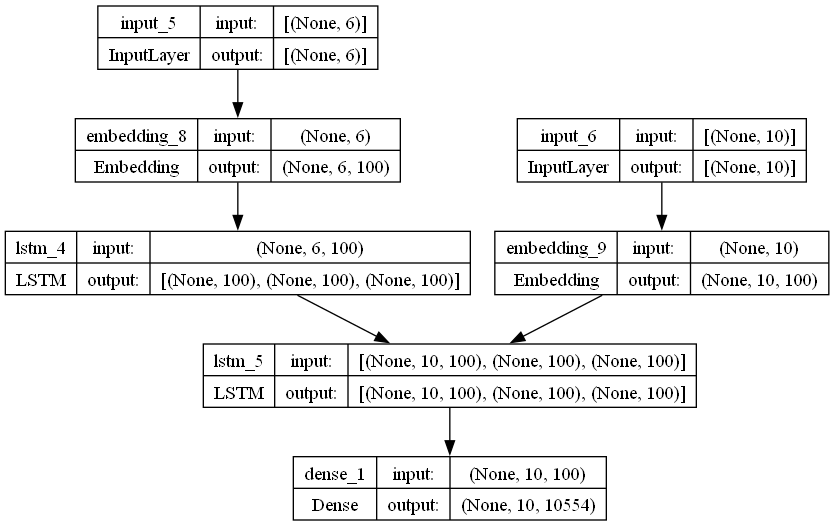

In [21]:
from keras.utils import plot_model

plot_model(model, to_file='models/model_trn_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
trn = model.fit([encoder_input_sequences, decoder_input_sequences],
               decoder_outputs_onehot, 
               batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1
               )

Epoch 1/5
282/282 [==============================] - 40s 121ms/step - loss: 3.2033 - accuracy: 0.6365 - val_loss: 2.7249 - val_accuracy: 0.6461
Epoch 2/5
282/282 [==============================] - 33s 116ms/step - loss: 2.2421 - accuracy: 0.7074 - val_loss: 2.6097 - val_accuracy: 0.6647
Epoch 3/5
282/282 [==============================] - 32s 114ms/step - loss: 2.1256 - accuracy: 0.7143 - val_loss: 2.4776 - val_accuracy: 0.6728
Epoch 4/5
282/282 [==============================] - 32s 114ms/step - loss: 2.0254 - accuracy: 0.7237 - val_loss: 2.3815 - val_accuracy: 0.6809
Epoch 5/5
282/282 [==============================] - 30s 108ms/step - loss: 1.9408 - accuracy: 0.7318 - val_loss: 2.3056 - val_accuracy: 0.6870


In [23]:

import pickle

pickle.dump(model, open('models/model_trn.sav', 'wb'))

In [24]:
encoder_model = Model(encoder_inputs, encoder_states)
print(encoder_model.summary())

Model: "model_2"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6)]               0         
                                                                 
 embedding_8 (Embedding)     (None, 6, 100)            374700    
                                                                 
 lstm_4 (LSTM)               [(None, 100),             80400     
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
Total params: 455100 (1.74 MB)
Trainable params: 455100 (1.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


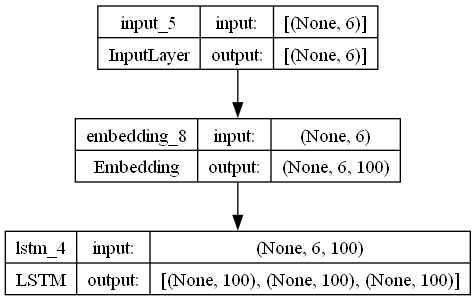

In [25]:
plot_model(encoder_model, to_file='models/model_prd_enc_plot.png', show_shapes=True, show_layer_names=True)

In [26]:

pickle.dump(encoder_model, open('models/model_prd_enc.sav', 'wb'))

In [27]:
decoder_input_h = Input(shape=(LSTM_NEURONS,))
decoder_input_c = Input(shape=(LSTM_NEURONS,))
decoder_input_states = [decoder_input_h, decoder_input_c]

decoder_input_word = Input(shape=(1,))
decoder_input_word_emb = decoder_embedding_layer(decoder_input_word)

decoder_outputs, h, c = decoder(decoder_input_word_emb, initial_state=decoder_input_states)
decoder_states = [h, c]

outputs = output_dense_layer(decoder_outputs)

In [28]:
decoder_model = Model([decoder_input_word]+decoder_input_states, [outputs]+decoder_states)
print(decoder_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_9 (Embedding)     multiple                     1055400   ['input_9[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 100)]                0         []                            
                                                                                            

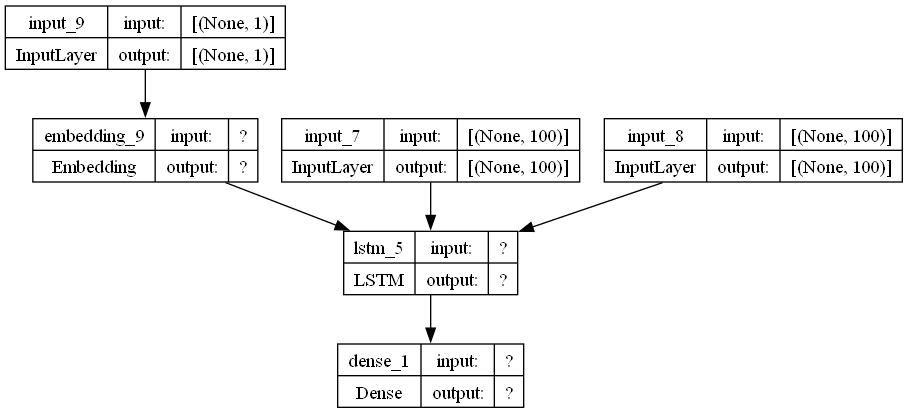

In [29]:
plot_model(decoder_model, to_file='models/model_prd_dec_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
pickle.dump(decoder_model, open('models/model_prd_dec.sav', 'wb'))

In [31]:
from numpy import argmax

index_to_word_input = {v:k for k,v in inputs_word2index.items()}
index_to_word_output = {v:k for k,v in outputs_word2index.items()}

def translate(input_seq):
    states = encoder_model.predict(input_seq)
    
    sos = outputs_word2index['<sos>']
    eos = outputs_word2index['<eos>']
    
    output_seq = zeros((1, 1))
    output_seq[0, 0] = sos
    
    output_sentence = []
    
    for _ in range(outputs_maxlen):
        output_tokens, h, c = decoder_model.predict([output_seq]+states)
        idx = argmax(output_tokens[0, 0, :])
        
        if idx == eos:
            break     
        word = ''
        if idx > 0:
            word = index_to_word_output[idx]
            output_sentence.append(word)
        
        states = [h, c]
        output_seq[0, 0] = idx
    
    return ' '.join(output_sentence)

In [33]:
from numpy import random

i = random.choice(len(inputs))
input_seq = encoder_input_sequences[i:i+1]
translation = translate(input_seq)

print('Input:', inputs[i])
print('Response:', translation)

1/1 [==============================] - 0s 22ms/step
Input: What should I buy?
Response: yo no gusta a tom.
